Ejemplos aleatorios: [926, 399, 441, 208]


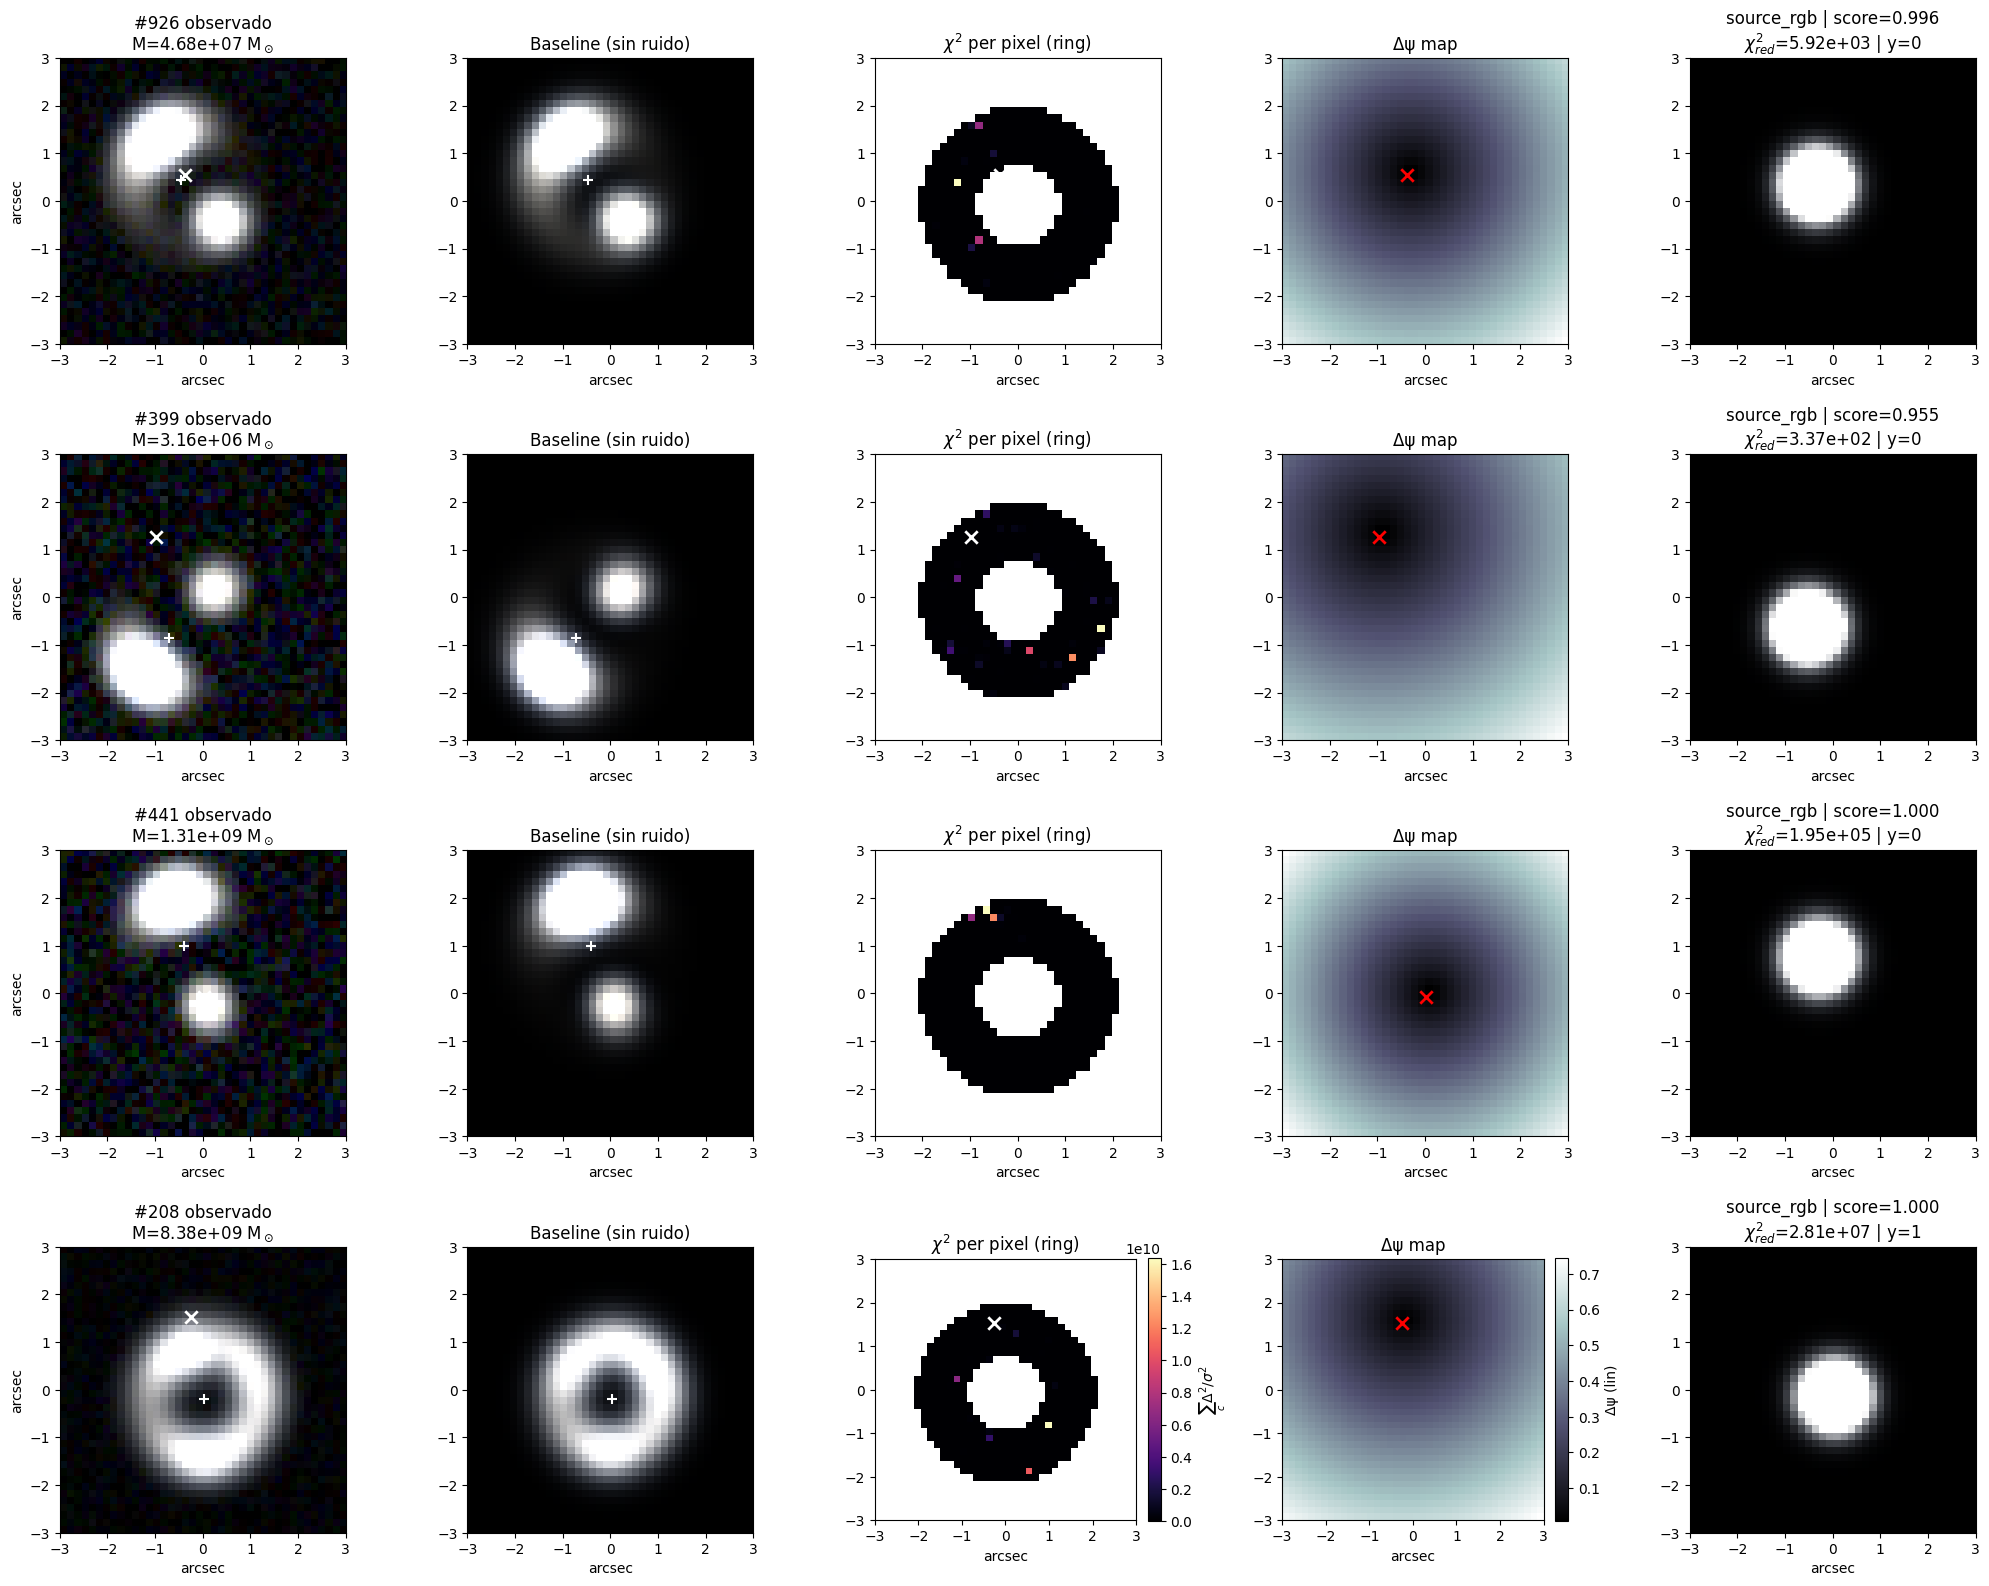

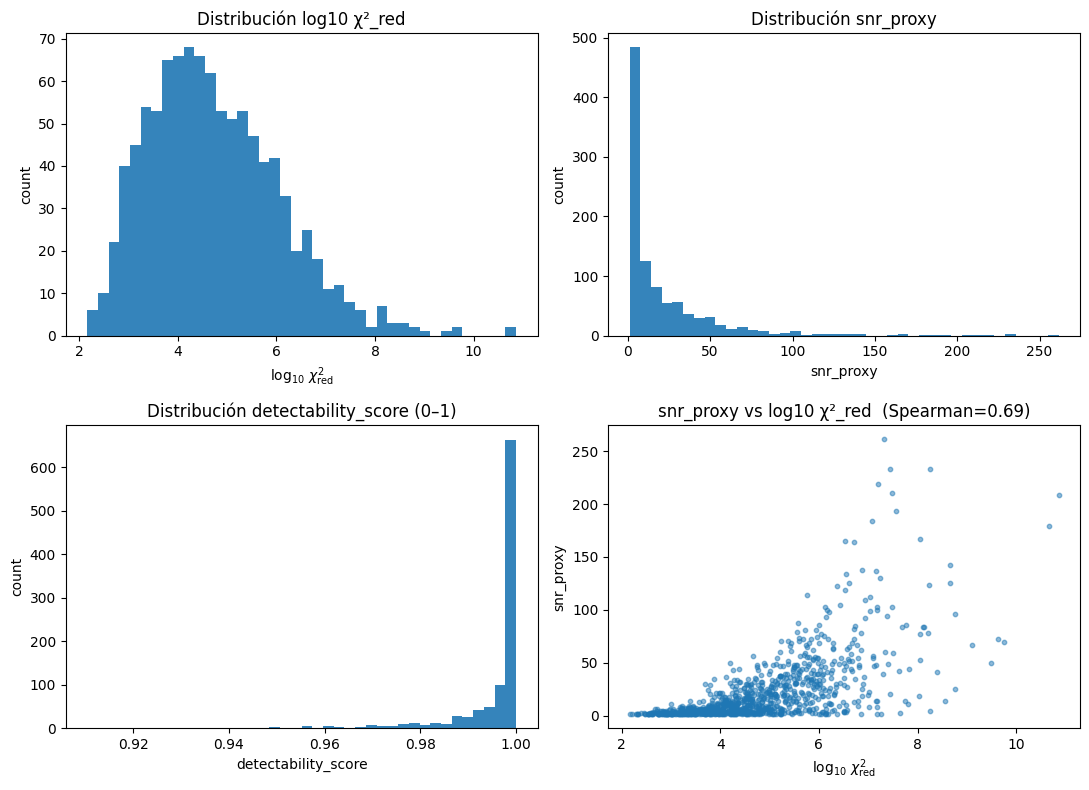

[Resumen] N=1000 | detectables=317 | no detectables=683 | prevalencia=0.32


In [3]:
# explore_lsst_lensing_h5 – random sampler + figura de diagnósticos en una sola figura
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ======================
# Parámetros
# ======================
h5_path = 'LSST_chi2_dataset.h5'   # ajusta si procede
N_EXAMPLES = 4                     # nº de ejemplos a mostrar
RANDOM_SEED = None                 # <-- pon None para muestras distintas cada vez
SHOW_RING_OVERLAY = False          # True para dibujar la máscara anular
# -----------------------------
# Helpers mínimos
# -----------------------------
def _pick_attr(attrs, name, default=None, cast=float):
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _extent_from_attrs(f, shape_hw=None):
    """Extent en arcsec para imshow."""
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    if shape_hw is None:
        return [-3, 3, -3, 3]
    H, W = shape_hw
    ps = _pick_attr(f.attrs, 'pixel_scale_arcsec', 0.15)
    return [-W*ps/2, W*ps/2, -H*ps/2, H*ps/2]

def _ring_mask_from_attrs(f, H, W):
    """Máscara anular centrada en el lente usando attrs del archivo."""
    ps = _pick_attr(f.attrs, 'pixel_scale_arcsec', 0.15)
    L  = _pick_attr(f.attrs, 'stamp_size_arcsec', ps*W)
    hx = np.linspace(-L/2 + ps/2, L/2 - ps/2, W)
    hy = np.linspace(-L/2 + ps/2, L/2 - ps/2, H)
    xx, yy = np.meshgrid(hx, hy)
    cx = _pick_attr(f.attrs, 'center_x_main', 0.0)
    cy = _pick_attr(f.attrs, 'center_y_main', -0.1)
    thetaE = _pick_attr(f.attrs, 'theta_E_main', 1.452)
    halfw  = _pick_attr(f.attrs, 'ring_halfwidth', 0.60)  # anillo más grueso por defecto
    r = np.hypot(xx - cx, yy - cy)
    return np.abs(r - thetaE) <= halfw

def _pclip(a, p=95):
    flat = a.reshape(-1)
    if flat.size == 0:
        return 1.0
    k = int(p/100.0 * (flat.size-1))
    return float(np.partition(flat, k)[k])

def _gri_to_rgb_show(img_gri, p=95):
    """
    Convierte (H,W,3) en orden (g,r,i) lineal -> RGB visual:
    RGB = (i, r, g) con stretch sqrt al percentil p por banda.
    """
    g = img_gri[..., 0]
    r = img_gri[..., 1]
    i = img_gri[..., 2]
    gmax = max(_pclip(g, p), 1e-9)
    rmax = max(_pclip(r, p), 1e-9)
    imax = max(_pclip(i, p), 1e-9)
    R = np.sqrt(np.clip(i/imax, 0, 1))
    G = np.sqrt(np.clip(r/rmax, 0, 1))
    B = np.sqrt(np.clip(g/gmax, 0, 1))
    return np.stack([R, G, B], axis=-1)

def _chi2_map(resid_sub_rgb, resid_null_rgb, eps=1e-12, mask=None):
    """
    χ² por píxel (sumando bandas) con Var = (cleanB-cleanA)^2.
    En el generador, cleanA es SIN ruido y cleanB CON ruido -> diff es solo ruido.
    """
    var_rgb = np.clip(resid_null_rgb**2, eps, None)
    chi2_pix = np.sum((resid_sub_rgb**2) / var_rgb, axis=-1)
    if mask is not None:
        chi2_pix = np.where(mask, chi2_pix, np.nan)
    return chi2_pix

def _safe_log10(x, lo=1e-12, hi=1e20):
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, hi))

# -----------------------------
# Visualización
# -----------------------------
with h5py.File(h5_path, 'r') as f:
    # claves esperadas del dataset actual
    k_obs   = 'images_rgb'          # con subhalo + ruido (g,r,i lineal)
    k_clean = 'images_clean'        # sin subhalo + SIN ruido (g,r,i lineal)
    k_rsub  = 'residual_rgb_sub'    # (N,H,W,3)
    k_rnul  = 'residual_rgb_null'   # (N,H,W,3)
    k_dpsi  = 'delta_psi_maps'      # (N,H,W)
    k_src   = 'source_rgb'          # (N,H,W,3) RGB LSST-like [0,1]

    X = f[k_obs]
    N, H, W, C = X.shape
    extent = _extent_from_attrs(f, (H, W))
    ring_mask = _ring_mask_from_attrs(f, H, W)

    # ======================
    # 1) Ejemplos aleatorios
    # ======================
    rng = (np.random.default_rng(RANDOM_SEED)
        if RANDOM_SEED is not None else
        np.random.default_rng())  # semilla no determinista

    n_examples = min(N_EXAMPLES, N)
    idxs = rng.choice(np.arange(N), size=n_examples, replace=False)
    print("Ejemplos aleatorios:", idxs.tolist())


    ncols = 5  # RGB obs | clean | χ² map | Δψ | source_rgb
    fig, axes = plt.subplots(len(idxs), ncols, figsize=(4*ncols, 4*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(idxs):
        mass  = f['subhalo_mass'][idx] if 'subhalo_mass' in f else np.nan
        x_sub = f['subhalo_x'][idx] if 'subhalo_x' in f else np.nan
        y_sub = f['subhalo_y'][idx] if 'subhalo_y' in f else np.nan
        x_src = f['source_x'][idx] if 'source_x' in f else np.nan
        y_src = f['source_y'][idx] if 'source_y' in f else np.nan

        chi2r = f['chi2_reduced'][idx] if 'chi2_reduced' in f else np.nan
        score = f['detectability_score'][idx] if 'detectability_score' in f else np.nan
        ybin  = f['is_detectable'][idx] if 'is_detectable' in f else -1

        col = 0
        # (1) observado: g,r,i -> RGB
        ax = axes[row, col]; col += 1
        ax.imshow(_gri_to_rgb_show(f[k_obs][idx]), origin='lower', extent=extent, interpolation='nearest')
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], s=80, marker='x', lw=2, c='w')
        if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], s=60, marker='+', lw=1.5, c='w')
        ax.set_title(f"#{idx} observado\nM={mass:.2e} M$_\\odot$")
        ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # (2) clean: g,r,i -> RGB (sin ruido)
        ax = axes[row, col]; col += 1
        clean_rgb = _gri_to_rgb_show(f[k_clean][idx])
        ax.imshow(clean_rgb, origin='lower', extent=extent, interpolation='nearest')
        if SHOW_RING_OVERLAY:
            # contorno de máscara (sencillo: puntos semitransparentes)
            mask = ring_mask
            yy, xx = np.where(mask)
            # proyectar a coordenadas arcsec:
            ps = _pick_attr(f.attrs, 'pixel_scale_arcsec', 0.15)
            x0 = -W*ps/2 + (xx + 0.5)*ps
            y0 = -H*ps/2 + (yy + 0.5)*ps
            ax.scatter(x0, y0, s=1, c='w', alpha=0.15)
        if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], s=60, marker='+', lw=1.5, c='w')
        ax.set_title("Baseline (sin ruido)"); ax.set_xlabel("arcsec")

        # (3) χ² per-pixel en el anillo
        resid_sub  = f[k_rsub][idx]
        resid_null = f[k_rnul][idx]
        chi2_pix = _chi2_map(resid_sub, resid_null, mask=ring_mask)
        ax = axes[row, col]; col += 1
        im = ax.imshow(chi2_pix, origin='lower', extent=extent, cmap='magma', interpolation='nearest')
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], s=80, marker='x', lw=2, c='w')
        ax.set_title(r"$\chi^2$ per pixel (ring)"); ax.set_xlabel("arcsec")
        if row == len(idxs)-1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel(r"$\sum_c \Delta^2/\sigma^2$")

        # (4) Δψ
        ax = axes[row, col]; col += 1
        im = ax.imshow(f[k_dpsi][idx], origin='lower', extent=extent, cmap='bone', interpolation='nearest')
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], s=80, marker='x', lw=2, c='r')
        ax.set_title("Δψ map"); ax.set_xlabel("arcsec")
        if row == len(idxs)-1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel("Δψ (lin)")

        # (5) source_rgb (ya es RGB en [0,1])
        ax = axes[row, col]; col += 1
        ax.imshow(f[k_src][idx], origin='lower', extent=extent, interpolation='nearest')
        ax.set_title(f"source_rgb | score={score:.3f}\n$\\chi^2_{{red}}$={chi2r:.2e} | y={int(ybin)}")
        ax.set_xlabel("arcsec")

    plt.tight_layout(); plt.show()

    # ===========================================
    # 2) DIAGNÓSTICOS EN UNA SOLA FIGURA (subplots)
    # ===========================================
    chi2r = f['chi2_reduced'][:] if 'chi2_reduced' in f else None
    snr   = f['snr_proxy'][:]    if 'snr_proxy' in f else None
    score = f['detectability_score'][:] if 'detectability_score' in f else None
    ybin  = f['is_detectable'][:] if 'is_detectable' in f else None

    # figura 2x2: dist χ²_red, dist snr, dist score (si hay), scatter χ² vs snr
    fig, axs = plt.subplots(2, 2, figsize=(11, 8))
    ax11, ax12 = axs[0]
    ax21, ax22 = axs[1]

    # (1,1) Distribución de log10 χ²_red
    if chi2r is not None:
        chi2_log = _safe_log10(chi2r)
        ax11.hist(chi2_log[np.isfinite(chi2_log)], bins=40, alpha=.9)
        ax11.set_xlabel(r'$\log_{10}\,\chi^2_{\rm red}$'); ax11.set_ylabel("count")
        ax11.set_title("Distribución log10 χ²_red")
    else:
        ax11.axis('off'); ax11.set_title("χ²_red no disponible")

    # (1,2) Distribución snr_proxy
    if snr is not None:
        ax12.hist(snr[np.isfinite(snr)], bins=40, alpha=.9)
        ax12.set_xlabel("snr_proxy"); ax12.set_ylabel("count")
        ax12.set_title("Distribución snr_proxy")
    else:
        ax12.axis('off'); ax12.set_title("snr_proxy no disponible")

    # (2,1) Distribución detectability_score (si existe)
    if score is not None:
        ax21.hist(score[np.isfinite(score)], bins=40, alpha=.9)
        ax21.set_xlabel("detectability_score"); ax21.set_ylabel("count")
        ax21.set_title("Distribución detectability_score (0–1)")
    else:
        ax21.axis('off'); ax21.set_title("detectability_score no disponible")

    # (2,2) Scatter: log10 χ²_red vs snr_proxy
    if (chi2r is not None) and (snr is not None):
        mask = np.isfinite(chi2_log) & np.isfinite(snr)
        rho, pval = spearmanr(chi2_log[mask], snr[mask]) if mask.any() else (np.nan, np.nan)
        ax22.scatter(chi2_log[mask], snr[mask], s=10, alpha=.5)
        ax22.set_xlabel(r'$\log_{10}\,\chi^2_{\rm red}$'); ax22.set_ylabel("snr_proxy")
        ax22.set_title(f"snr_proxy vs log10 χ²_red  (Spearman={rho:.2f})")
    else:
        ax22.axis('off'); ax22.set_title("scatter no disponible")

    plt.tight_layout(); plt.show()

    # Resumen de conteos de detectables (si hay)
    if ybin is not None:
        ybin = ybin.astype(int)
        n_pos = int((ybin == 1).sum())
        n_neg = int((ybin == 0).sum())
        print(f"[Resumen] N={N} | detectables={n_pos} | no detectables={n_neg} | prevalencia={n_pos/max(N,1):.2f}")


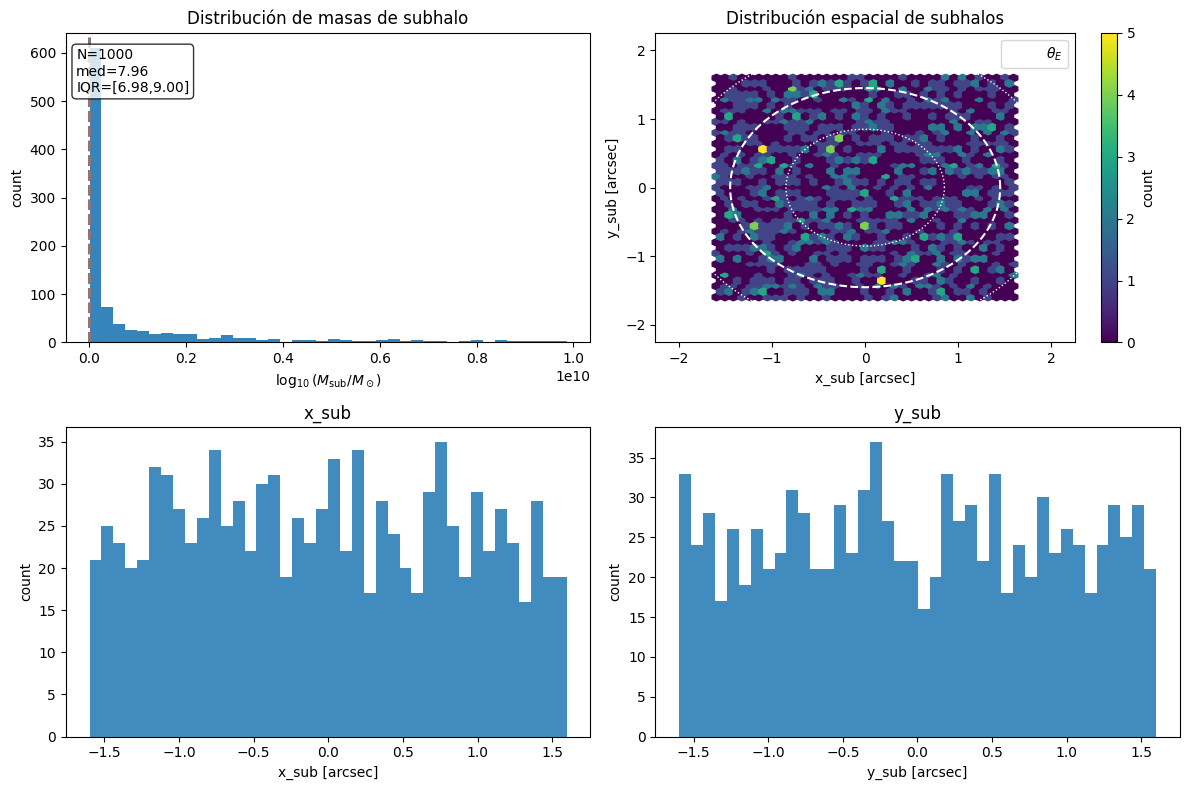

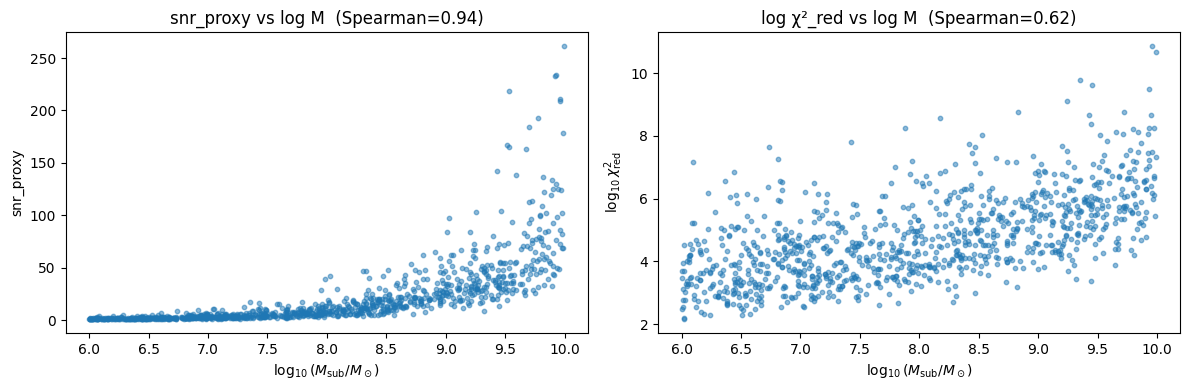

In [5]:
# === Distribuciones de masa y posiciones del subhalo ===
import h5py, numpy as np, matplotlib.pyplot as plt
from scipy.stats import spearmanr

h5_path = "LSST_chi2_dataset.h5"  # ajusta si procede

def _pick_attr(attrs, name, default=None, cast=float):
    try:
        return cast(attrs[name])
    except Exception:
        return default

with h5py.File(h5_path, "r") as f:
    M = f["subhalo_mass"][:]          # (N,) en M_sun
    x = f["subhalo_x"][:]             # (N,) arcsec
    y = f["subhalo_y"][:]             # (N,) arcsec
    chi2r = f["chi2_reduced"][:] if "chi2_reduced" in f else None
    snr   = f["snr_proxy"][:]    if "snr_proxy" in f else None

    # Parámetros del anillo para referencia visual
    thetaE = _pick_attr(f.attrs, "theta_E_main", 1.452)
    halfw  = _pick_attr(f.attrs, "ring_halfwidth", 0.60)

N = M.size
logM = np.log10(M)

# --- Figura 1: histogramas de masa y posiciones ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax11, ax12 = axs[0]
ax21, ax22 = axs[1]

# (1,1) Histograma log10(M)
n, bins, _ = ax11.hist(M, bins=40, alpha=.9)
ax11.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$'); ax11.set_ylabel('count')
ax11.set_title('Distribución de masas de subhalo')
med, q1, q3 = np.median(logM), np.quantile(logM, 0.25), np.quantile(logM, 0.75)
for v, c, lbl in [(q1,'gray','Q1'), (med,'r','mediana'), (q3,'gray','Q3')]:
    ax11.axvline(v, color=c, ls='--', lw=2)
ax11.text(0.02, 0.95, f'N={N}\nmed={med:.2f}\nIQR=[{q1:.2f},{q3:.2f}]',
          transform=ax11.transAxes, va='top', ha='left',
          bbox=dict(boxstyle='round', fc='white', alpha=.8))

# (1,2) 2D hexbin de posiciones (x,y)
hb = ax12.hexbin(x, y, gridsize=35, cmap='viridis')
ax12.set_xlabel('x_sub [arcsec]'); ax12.set_ylabel('y_sub [arcsec]')
ax12.set_title('Distribución espacial de subhalos')
cb = plt.colorbar(hb, ax=ax12); cb.set_label('count')
# Círculo de Einstein y anillo de la métrica
th = np.linspace(0, 2*np.pi, 400)
ax12.plot(thetaE*np.cos(th), thetaE*np.sin(th), 'w--', lw=1.5, label=r'$\theta_E$')
ax12.plot((thetaE+halfw)*np.cos(th), (thetaE+halfw)*np.sin(th), 'w:', lw=1)
ax12.plot((thetaE-halfw)*np.cos(th), (thetaE-halfw)*np.sin(th), 'w:', lw=1)
ax12.legend(loc='upper right')

# (2,1) Histogramas marginales de x e y
ax21.hist(x, bins=40, alpha=.85)
ax21.set_xlabel('x_sub [arcsec]'); ax21.set_ylabel('count'); ax21.set_title('x_sub')
ax22.hist(y, bins=40, alpha=.85)
ax22.set_xlabel('y_sub [arcsec]'); ax22.set_ylabel('count'); ax22.set_title('y_sub')

plt.tight_layout(); plt.show()

# --- Figura 2 (opcional): relaciones con detectabilidad ---
if (snr is not None) or (chi2r is not None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # (a) logM vs snr_proxy
    if snr is not None:
        r_snr, p_snr = spearmanr(logM, snr)
        axes[0].scatter(logM, snr, s=10, alpha=.5)
        axes[0].set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$'); axes[0].set_ylabel('snr_proxy')
        axes[0].set_title(f'snr_proxy vs log M  (Spearman={r_snr:.2f})')
    else:
        axes[0].axis('off'); axes[0].set_title('snr_proxy no disponible')

    # (b) logM vs log10 χ²_red
    if chi2r is not None:
        logC = np.log10(np.clip(chi2r, 1e-12, 1e20))
        r_c2, p_c2 = spearmanr(logM, logC)
        axes[1].scatter(logM, logC, s=10, alpha=.5)
        axes[1].set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$'); axes[1].set_ylabel(r'$\log_{10}\chi^2_{\rm red}$')
        axes[1].set_title(f'log χ²_red vs log M  (Spearman={r_c2:.2f})')
    else:
        axes[1].axis('off'); axes[1].set_title('χ²_red no disponible')

    plt.tight_layout(); plt.show()


(array([18., 20., 28., 24., 17., 24., 26., 31., 37., 23., 27., 15., 27.,
        23., 19., 27., 29., 31., 26., 31., 21., 23., 27., 16., 25., 26.,
        27., 16., 16., 30., 28., 24., 25., 28., 29., 24., 24., 32., 23.,
        33.]),
 array([6.18692291e+06, 2.55887742e+08, 5.05588560e+08, 7.55289379e+08,
        1.00499020e+09, 1.25469102e+09, 1.50439184e+09, 1.75409265e+09,
        2.00379347e+09, 2.25349429e+09, 2.50319511e+09, 2.75289593e+09,
        3.00259675e+09, 3.25229757e+09, 3.50199838e+09, 3.75169920e+09,
        4.00140002e+09, 4.25110084e+09, 4.50080166e+09, 4.75050248e+09,
        5.00020330e+09, 5.24990412e+09, 5.49960493e+09, 5.74930575e+09,
        5.99900657e+09, 6.24870739e+09, 6.49840821e+09, 6.74810903e+09,
        6.99780985e+09, 7.24751066e+09, 7.49721148e+09, 7.74691230e+09,
        7.99661312e+09, 8.24631394e+09, 8.49601476e+09, 8.74571558e+09,
        8.99541640e+09, 9.24511721e+09, 9.49481803e+09, 9.74451885e+09,
        9.99421967e+09]),
 <BarContainer objec

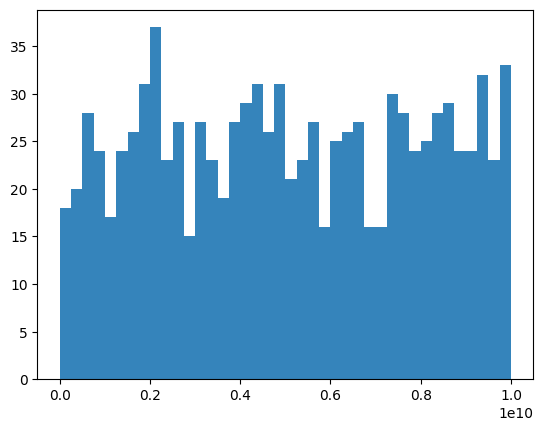

In [24]:
m=[]
for i in range(1000):
    m.append(rng.uniform(1e6, 1e10))
plt.hist(m, bins=40, alpha=.9)


AttributeError: 'NoneType' object has no attribute 'shape'

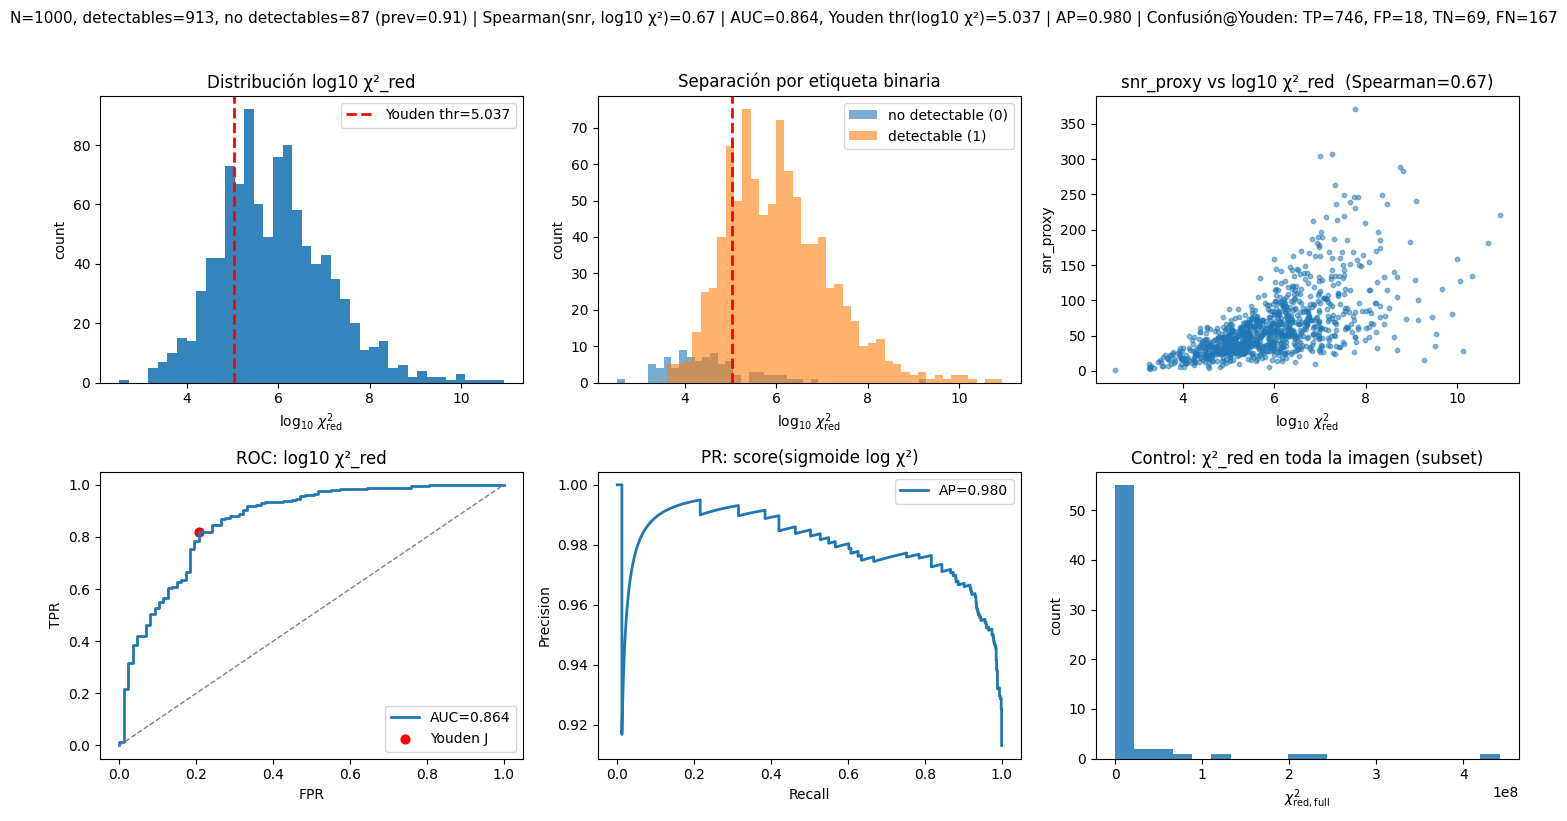

In [6]:
# === Un solo figure con todos los diagnósticos de detectabilidad (con conteos y métricas) ===
import h5py, numpy as np, matplotlib.pyplot as plt

try:
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
    HAS_SK = True
except Exception:
    HAS_SK = False

from scipy.stats import spearmanr

h5_path = "LSST_chi2_dataset.h5"   # <- ajusta si es necesario
EPS = 1e-12

def safe_log10(x, lo=1e-12, hi=1e20):
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, hi))

def chi2_full(resid_sub_rgb, resid_null_rgb, eps=1e-12):
    """χ² y χ²_red en TODA la imagen (suma de bandas)."""
    var = np.clip(resid_null_rgb**2, eps, None)
    chi2_pix = np.sum((resid_sub_rgb**2)/var, axis=-1)  # (H,W)
    chi2 = float(np.nansum(chi2_pix))
    dof  = int(np.isfinite(chi2_pix).sum())
    return chi2, chi2/dof

def chi2_to_score_sigmoid(chi2_red, a=2.0, b=1.0):
    x = safe_log10(chi2_red)
    return 1.0 / (1.0 + np.exp(-a*(x - b)))

# ---- Cargar datasets ----
with h5py.File(h5_path, "r") as f:
    chi2_red = f["chi2_reduced"][:]
    ybin = f["is_detectable"][:] if "is_detectable" in f else None
    snr  = f["snr_proxy"][:]     if "snr_proxy"     in f else None
    resid_sub  = f["residual_rgb_sub"][:]   # (N,H,W,3)
    resid_null = f["residual_rgb_null"][:]  # (N,H,W,3)

chi2_log = safe_log10(chi2_red)
N = chi2_red.size

# ---- χ²_full (control) en subset ----
Ncheck = min(64, resid_sub.shape[0])
chi2_fullred_list = np.zeros(Ncheck, dtype=float)
for i in range(Ncheck):
    _, c2r = chi2_full(resid_sub[i], resid_null[i], eps=EPS)
    chi2_fullred_list[i] = c2r

# ---- Métricas y conteos globales ----
counts_txt = []
youden_thr = None
roc_auc = None
ap_score = None
spearman_rho = None

if ybin is not None:
    ybin = ybin.astype(int)
    n_pos = int((ybin == 1).sum())
    n_neg = N - n_pos
    prevalence = n_pos / max(N, 1)
    counts_txt.append(f"N={N}, detectables={n_pos}, no detectables={n_neg} (prev={prevalence:.2f})")
else:
    counts_txt.append(f"N={N} (sin etiquetas binarias)")

if snr is not None:
    spearman_rho, pval = spearmanr(chi2_log, snr)
    counts_txt.append(f"Spearman(snr, log10 χ²)={spearman_rho:.2f}")

# ROC / PR y umbral de Youden sobre log10(χ²)
if HAS_SK and (ybin is not None):
    fpr, tpr, thr = roc_curve(ybin, chi2_log)
    roc_auc = auc(fpr, tpr)
    j = tpr - fpr
    j_ix = int(np.argmax(j))
    youden_thr = thr[j_ix]  # umbral en log10(χ²_red)
    counts_txt.append(f"AUC={roc_auc:.3f}, Youden thr(log10 χ²)={youden_thr:.3f}")

    # PR con score sigmoidal 0–1
    score_sig = chi2_to_score_sigmoid(chi2_red, a=2.0, b=1.0)
    prec, rec, _ = precision_recall_curve(ybin, score_sig)
    ap_score = average_precision_score(ybin, score_sig)
    counts_txt.append(f"AP={ap_score:.3f}")

    # Matriz de confusión usando umbral de Youden en log10(χ²)
    yhat = (chi2_log >= youden_thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(ybin, yhat).ravel()
    counts_txt.append(f"Confusión@Youden: TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# ---- Layout de una sola figura ----
# 2 filas x 3 columnas: [hist log χ², hist por clase, scatter SNR]
#                       [ROC, PR, hist χ²_full_red]
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
ax11, ax12, ax13 = axes[0]
ax21, ax22, ax23 = axes[1]

# (1,1) Hist log10 χ²_red (marca el umbral si existe)
n_, bins_, _ = ax11.hist(chi2_log, bins=40, alpha=.9)
if youden_thr is not None:
    ax11.axvline(youden_thr, color='r', lw=2, ls='--', label=f"Youden thr={youden_thr:.3f}")
    ax11.legend()
ax11.set_xlabel(r'$\log_{10}\,\chi^2_{\rm red}$'); ax11.set_ylabel("count")
ax11.set_title("Distribución log10 χ²_red")

# (1,2) Hist por clase (si hay etiquetas)
if ybin is not None:
    ax12.hist(chi2_log[ybin==0], bins=40, alpha=.6, label="no detectable (0)")
    ax12.hist(chi2_log[ybin==1], bins=40, alpha=.6, label="detectable (1)")
    if youden_thr is not None:
        ax12.axvline(youden_thr, color='r', lw=2, ls='--')
    ax12.set_xlabel(r'$\log_{10}\,\chi^2_{\rm red}$'); ax12.set_ylabel("count")
    ax12.set_title("Separación por etiqueta binaria")
    ax12.legend()
else:
    ax12.axis('off'); ax12.set_title("is_detectable no disponible")

# (1,3) SNR vs log10 χ²_red (si hay snr_proxy)
if snr is not None:
    rho, pval = spearmanr(chi2_log, snr)
    ax13.scatter(chi2_log, snr, s=10, alpha=.5)
    ax13.set_xlabel(r'$\log_{10}\,\chi^2_{\rm red}$'); ax13.set_ylabel("snr_proxy")
    ax13.set_title(f"snr_proxy vs log10 χ²_red  (Spearman={rho:.2f})")
else:
    ax13.axis('off'); ax13.set_title("snr_proxy no disponible")

# (2,1) ROC (si hay sklearn y etiquetas)
if HAS_SK and (ybin is not None):
    ax21.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
    ax21.plot([0,1],[0,1],'--', lw=1, color='gray')
    ax21.scatter(fpr[j_ix], tpr[j_ix], s=40, c='r', label="Youden J")
    ax21.set_xlabel("FPR"); ax21.set_ylabel("TPR")
    ax21.set_title("ROC: log10 χ²_red")
    ax21.legend()
else:
    ax21.axis('off'); ax21.set_title("ROC (requiere sklearn & etiquetas)")

# (2,2) PR (si hay sklearn y etiquetas)
if HAS_SK and (ybin is not None):
    ax22.plot(rec, prec, lw=2, label=f"AP={ap_score:.3f}")
    ax22.set_xlabel("Recall"); ax22.set_ylabel("Precision")
    ax22.set_title("PR: score(sigmoide log χ²)")
    ax22.legend()
else:
    ax22.axis('off'); ax22.set_title("PR (requiere sklearn & etiquetas)")

# (2,3) χ²_red en TODA la imagen (control)
ax23.hist(chi2_fullred_list, bins=20, alpha=.85)
ax23.set_xlabel(r'$\chi^2_{\rm red,full}$'); ax23.set_ylabel("count")
ax23.set_title("Control: χ²_red en toda la imagen (subset)")

# ---- Supertítulo con resumen numérico ----
fig.suptitle(" | ".join(counts_txt), y=1.02, fontsize=11)
plt.tight_layout()
plt.show()
